[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part1/blob/main/MOOC_Notebooks/Notebook07_ComplexMLRegression.ipynb)

# Notebook 07: Complex ML Regression [MOOC Colab Version]

Authors: Randy J. Chase, David R. Harrison, Amanda Burke, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning](https://journals.ametsoc.org/view/journals/wefo/37/8/WAF-D-22-0070.1.xml)<br>
Original Github: [WAF_ML_Tutorial_Part1](https://github.com/ai2es/WAF_ML_Tutorial_Part1)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Burke, A., Lackmann, G. M., & McGovern, A. (2022). A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning, Weather and Forecasting, 37(8), 1509-1529.

### Goal: Training a ML using all features/predictors/inputs 

#### Reminder of Problem Statement


Reminder of the ML task we want to accomplish in the paper. 

1. Does this image contain a thunderstorm? <-- Classification
2. How many lightning flashes are in this image? <-- Regression

#### Background

Please make sure you already did Notebook 5, because this notebook extends what we did in Notebook 5 to now include many more input predictors. This is the same thing as Notebook 6, but for the regression task.

#### Step 0: Get the github repo (we need some of the functions there)

The first step with all of these Google Colab notebooks will be to grab the github repo and cd into the notebooks directory. 

To run things from the command line, put a ```!``` before your code

In [1]:
#get the github repo 
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part1.git 

#cd into the repo so the paths work 
import os 
os.chdir('/content/WAF_ML_Tutorial_Part1/jupyter_notebooks/')

Cloning into 'WAF_ML_Tutorial_Part1'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 301 (delta 139), reused 236 (delta 96), pack-reused 0
Receiving objects: 100% (301/301), 195.77 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (100/100), done.


#### Step 1 & 2: Import packages and load data for Classification  
In Notebook 5 we only wanted 1 feature, no we want all available inputs (36 total). So all we need to change is the ```features_to_keep``` keyword to include all indices. Remember in notebook 5 we wanted to drop the zeros to help. lets do that right away

In [2]:
#needed packages 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='../datasets/sevir/',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)

I have a habit of always checking shapes, so let's do that 

In [4]:
print('X_train, y_train shapes: {},{}'.format(X_train.shape,y_train.shape))
print('X_val, y_val shapes: {},{}'.format(X_validate.shape,y_validate.shape))
print('X_test, y_test shapes: {},{}'.format(X_test.shape,y_test.shape))

X_train, y_train shapes: (222051, 36),(222051,)
X_val, y_val shapes: (47319, 36),(47319,)
X_test, y_test shapes: (47376, 36),(47376,)


Good, these shapes are indeed less than the classification task (Notebook 6) because we are dropping the zeros.

#### Change from Notebook 5

Since we are using more than 1 input predictor it is important to normalize our predictors. Why is this important? because in reality each one of our inputs have a range of valid values associated with them, and that range could be large (e.g., -100 to 100) or it could be small (e.g., 0,1). The machine learning will weight these inputs quantitatively, so if we use the default scalings, it might be biased to use the larger magnitude predictors more than the small magnitude predictors. To prevent this we will scale the data to have mean 0, and variance 1. You are likely more familiar with the term *standard anomaly* which is the same thing: 

$$ z = \frac{x - \mu}{\sigma} $$

where $\mu$ is the mean of that specific feature and $\sigma$ is the standard deviation, both calculated from the training dataset. We could implement this ourselves, but ```sklearn``` has this built for us: ```sklearn.preprocessing.StandardScaler``` and it works alot like how we fit the machine learning model before.

In [5]:
from sklearn.preprocessing import StandardScaler

#create scaling object 
scaler = StandardScaler()
#fit scaler to training data
scaler.fit(X_train)

#transform feature data into scaled space 
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

#double check that mean is 0 and std is 1. 
np.mean(X_train,axis=0),np.std(X_train,axis=0)

(array([ 7.74633690e-16, -1.56667488e-16, -2.87735713e-16, -2.57528583e-16,
         2.30393364e-17,  2.35513217e-17, -6.94380001e-17, -7.21899209e-17,
         1.77530887e-16,  2.40223481e-15, -6.88108182e-16, -4.63858640e-16,
        -6.53293185e-16,  3.88852801e-16, -4.31987558e-16, -2.67256303e-16,
         1.10550416e-15, -2.05306087e-16,  1.10076830e-17,  2.81591890e-18,
        -3.83988941e-17, -1.47195761e-16, -1.43355871e-17, -4.91505844e-17,
        -3.99348498e-17,  9.62532278e-17,  1.97370316e-16, -2.45752922e-17,
        -2.96951448e-17,  1.04956977e-17, -3.96788572e-18,  4.09588204e-18,
        -3.59029660e-17, -3.83988941e-19,  3.21270747e-17,  3.47637988e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]))

Note that e-16 means $\times 10^{-16}$ which is effectively 0. So it has successfully scaled our data to now have mean 0 and std 1. We are now ready to train our machine learning model again.

#### Step 3: Initialize model

To keep consistency with Notebook 5, we will continue using linear regression

In [6]:
#load model from sklearn
from sklearn.linear_model import LinearRegression

#initialize
model = LinearRegression()

print(model)


LinearRegression()


#### Step 4: Train your ML model! 

In [7]:
model = model.fit(X_train,y_train)

#### Step 5: Evaluate your ML model

As a sanity check, we will first look at the *one-to-one* plot where the x-axis is the predicted number of flashes, and the y-axis is the true number of flashes. A perfect prediction will be directly along the diagonal. 

Text(0.5, 0, 'GLM measurement, [$number of flashes$]')

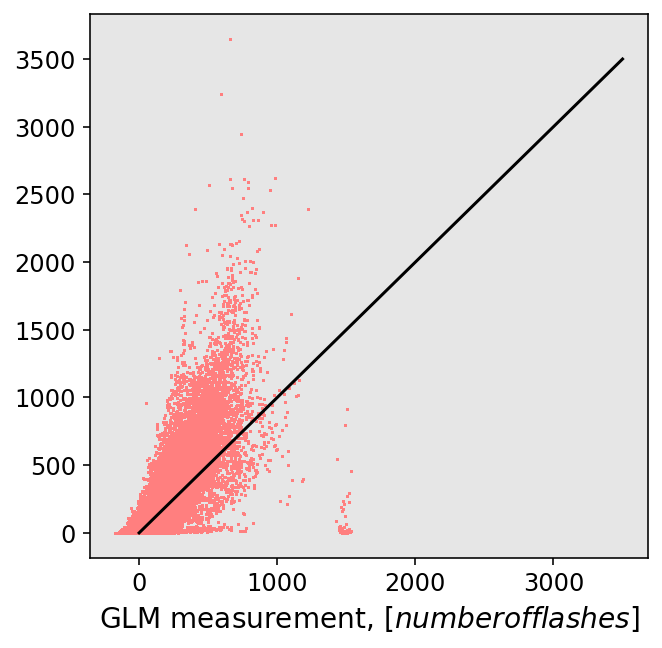

In [8]:
#get predictions 
yhat = model.predict(X_validate)

#color I like. The order of ratios is [Red,Green,Blue]
r = [255/255,127/255,127/255]

#make figure  
fig = plt.figure(figsize=(5,5))
#set background color to white so we can copy paste out of the notebook if we want 
fig.set_facecolor('w')

#get axis for drawing
ax = plt.gca()

#plot data 
ax.scatter(yhat,y_validate,color=r,s=1,marker='+')
ax.plot([0,3500],[0,3500],'-k')
ax.set_xlabel('ML Prediction, [$number of flashes$]')
ax.set_xlabel('GLM measurement, [$number of flashes$]')

To me this looks better than the 1 input feature model we showed in Notebook 5. One troubling thing with these types of scatter plots though is that there are so many points, it is hard to see where the 'mode' of the distribution is. To look a bit deeper into this plot, and to match the plots we used in the paper (Figures 14 and 16). I have a function that will go ahead and bin up the data on this plot and count how many points are in each bin. This function is called ```boxbin``` and it is located in the ```aux_functions.py``` script

n_samples= 27668.0


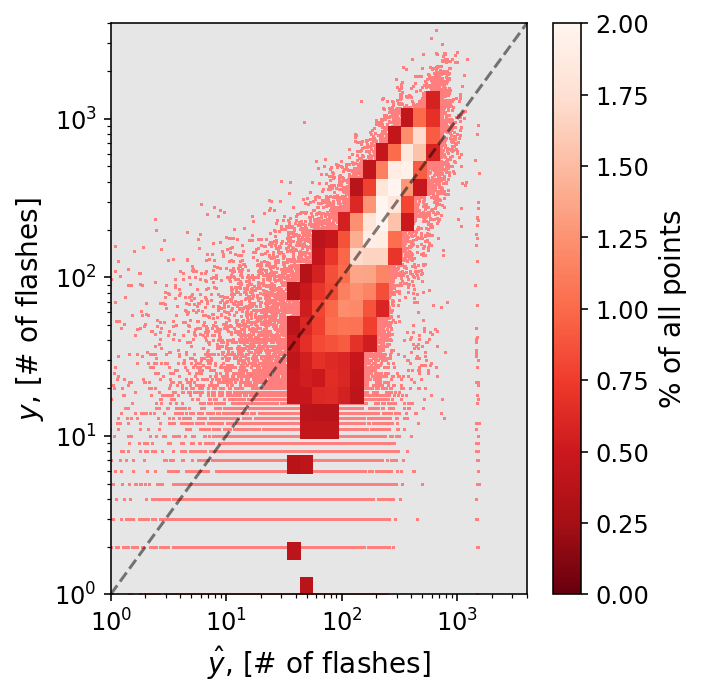

In [9]:
from aux_functions import boxbin

#make figure  
fig = plt.figure(figsize=(5,5))
#set background color to white so we can copy paste out of the notebook if we want 
fig.set_facecolor('w')

#get axis for drawing
ax = plt.gca()

#build the bins we want to use for our data
n = 33
xbins = np.logspace(0,3.5,n) #this logspace logarithmically spaces bins from 10^0 to 10^3.5. The lightning data is better shown on a log-log scale
ybins = np.logspace(0,3.5,n) #we choose to keep the bins square 

#Color I like
r = [255/255,127/255,127/255]

#make axes log-log 
ax.semilogy()
ax.semilogx()
#same scatter as before 
ax.scatter(yhat,y_validate,color=r,s=1,marker='+')

#use the boxbin function to bin data!
ax,cbar,C = boxbin(yhat,y_validate,xbins,ybins,ax=ax,mincnt=100,normed=True,cmap='Reds_r',vmin=0,vmax=2)

cbar.set_label('$\%$ of all points')
ax.set_xlim([1,4000])
ax.set_xticks([1,10,100,1000])
ax.set_yticks([1,10,100,1000])
ax.set_ylim([1,4000])
ax.plot([1,4000],[1,4000],'--k',alpha=0.5)
    
ax.set_ylabel('$y$, [# of flashes]')
ax.set_xlabel(r'$\hat{y}$, [# of flashes]')
    
    
plt.tight_layout()

Ah that’s better, we can now see where the highest density of points are. Note that only bins with more than 100 points in them will be colored in the boxes. 

Let's check on the quantitative metrics to see if it is indeed working better with more features. We will calculate these: 

$$ \mathrm{Bias} =  \frac{1}{N} \sum_{j=1}^{N} (y_j - \hat{y}_j) $$

$$ \mathrm{MAE} = \frac{1}{N} \sum_{j=1}^{N} |y_j - \hat{y}_j| $$

$$ \mathrm{RMSE} = \sqrt{\frac{1}{N}  \sum_{j=1}^{N} (y_j - \hat{y}_j)^{2}} $$ 

$$ \mathrm{R^{2}} = 1 - \frac{\sum_{j=1}^{N} (y_j - \hat{y}_j)^{2}}{\sum_{j=1}^{N} (y_j - \bar{y})^{2}} $$

All of these metrics again in the ```gewitter_functions.py``` script.

In [10]:
from gewitter_functions import get_mae,get_rmse,get_bias,get_r2

yhat = model.predict(X_validate)
mae = get_mae(y_validate,yhat)
rmse = get_rmse(y_validate,yhat)
bias = get_bias(y_validate,yhat)
r2 = get_r2(y_validate,yhat)

#print them out so we can see them 
print('MAE:{} flashes, RMSE:{} flashes, Bias:{} flashes, Rsquared:{}'.format(np.round(mae,2),np.round(rmse,2),np.round(bias,2),np.round(r2,2)))

MAE:97.6 flashes, RMSE:174.14 flashes, Bias:31.88 flashes, Rsquared:0.56


The numbers from the single feature model are: *MAE:146.68 flashes, RMSE:235.46 flashes, Bias:30.98 flashes, Rsquared:0.2*. So things have indeed improved on the MAE, Bias and Rsquared metrics. But this is a linear model, so trying to use a linear model for a non-linear forecast (like the number of flashes in a satellite image) is not great, but does do ok.  